In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# unscaled, log-normalized counts, with conditions subsampled to the same number of cells 
# and 2000 highly variable genes calculated jointly across all perturbation conditions, including control, using scanpy28 with default parameters (Supplementary Methods)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import os
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import string

In [4]:
p = "../evaluation_results/nlof/"
outlier_dfs = {f.split(".")[0]: pd.read_csv(os.path.join(p, f)).reset_index().rename({"level_0": "Test group"}, axis=1).drop(["index", "Unnamed: 0"], axis=1).sort_values("Test group") for f in os.listdir(p)}

In [5]:
outlier_dfs

{'sciplex_A549':         Test group  level_1  Negative outlier factor  in matching
 46457         10.0     3740                -1.498969         True
 46458         10.0     3741                -1.347388         True
 46459         10.0     3742                -1.684428         True
 46460         10.0     3743                -1.946996         True
 46461         10.0     3744                -1.811922         True
 ...            ...      ...                      ...          ...
 173372     10000.0    39574                -2.083234         True
 173373     10000.0    39575                -1.414497         True
 173374     10000.0    39576                -1.869653        False
 173375     10000.0    39577                -1.845426         True
 173319     10000.0    39521                -1.769820         True
 
 [173378 rows x 4 columns],
 'sciplex_K562':         Test group  level_1  Negative outlier factor  in matching
 184919        10.0    49847                -2.145566         True


In [6]:
outlier_dfs["sciplex_MCF7"]["Test group"].unique()

array([   10.,   100.,  1000., 10000.])

In [7]:
p_vals = list()
for i, dataset in enumerate(outlier_dfs):
    for j, test_group in enumerate(outlier_dfs[dataset]["Test group"].unique()):
        subset_true = outlier_dfs[dataset][(outlier_dfs[dataset]["Test group"] == test_group) & (outlier_dfs[dataset]["in matching"] == True)]["Negative outlier factor"]
        subset_false = outlier_dfs[dataset][(outlier_dfs[dataset]["Test group"] == test_group) & (outlier_dfs[dataset]["in matching"] == False)]["Negative outlier factor"]
        p_val = mannwhitneyu(subset_false, subset_true, alternative="less").pvalue
        p_vals.append(p_val)

In [8]:
datasets = outlier_dfs.keys()

In [9]:
p_adjs = multipletests(p_vals, method="fdr_bh")[1]

In [10]:
p_vals

[np.float64(6.163970457385684e-210),
 np.float64(4.631374897090066e-218),
 np.float64(5.0419293020704277e-197),
 np.float64(1.135505961225095e-167),
 np.float64(0.0),
 np.float64(5.57295575183242e-295),
 np.float64(1.3059946941302752e-283),
 np.float64(1.8901852405672373e-183),
 np.float64(7.676427994632501e-301),
 np.float64(1.983149286403328e-176),
 np.float64(9.048780657117706e-211),
 np.float64(2.1950221626286154e-224)]

In [11]:
p_adjs

array([9.24595569e-210, 9.26274979e-218, 6.72257240e-197, 1.13550596e-167,
       0.00000000e+000, 2.22918230e-294, 3.91798408e-283, 2.26822229e-183,
       4.60585680e-300, 2.16343559e-176, 1.55121954e-210, 5.26805319e-224])

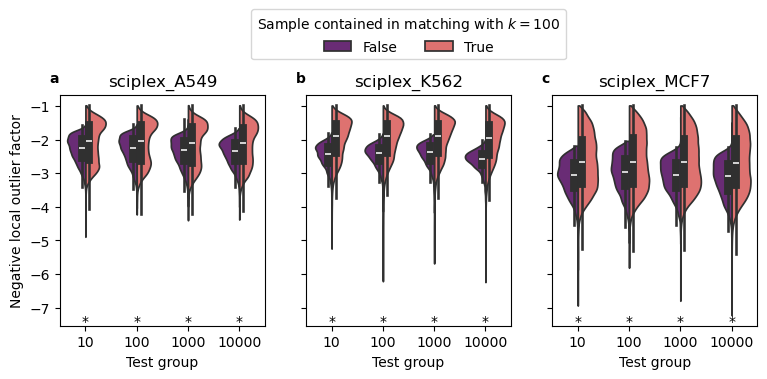

In [23]:
f, axs = plt.subplots(1, 3, figsize=(9, 3), sharey=True)
labels = string.ascii_lowercase  
j_steps = int(len(p_adjs) / len(outlier_dfs))

for i, dataset in enumerate(outlier_dfs):
    df = outlier_dfs[dataset]
    df["Test group"] = df["Test group"].astype(int)
    legend = False if i != 1 else "full"
    sns.violinplot(df, y="Negative outlier factor", hue="in matching", x="Test group", cut=0, split=True, palette="magma", ax=axs[i], legend=legend) 
    axs[i].set_title(dataset)
    axs[i].set_ylabel("Negative local outlier factor")

    for j in range(0, j_steps):
        axs[i].text(j, -7.6, "*", ha="center", va="bottom", fontsize=10, color="black")

    axs[i].text(
        -0.05, 1.1,  # Position (normalized figure coordinates)
        labels[i],   # Corresponding letter
        transform=axs[i].transAxes,  # Relative to subplot
        fontsize=10, fontweight='bold', va='top', ha='left'
    )

axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), ncol=2, title="Sample contained in matching with $k=100$")
plt.savefig("../plots/nof.pdf", bbox_inches="tight")

In [13]:
if 0:
    outlier_dfs = {k: outlier_dfs[k].set_index("Test group") for k in outlier_dfs}
    print(pd.DataFrame([p_vals, p_adjs], index=["$P$", "$P_{adj}$"], columns=pd.concat(outlier_dfs).index.unique()).to_latex())